<a href="https://colab.research.google.com/github/ErumUmer/CIND820_Capstone_Project/blob/main/Iram_ames_house_price_part1_replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Ames House Price - Advanced Regression Techniques

**Import libraries**

In [159]:
# Import necessary libraries
import numpy as np  # NumPy is a library for numerical operations
import pandas as pd  # Pandas is a library for data manipulation and analysis
import matplotlib.pyplot as plt  # Matplotlib is used for creating plots and visualizations
import seaborn as sns  # Seaborn is a data visualization library built on top of Matplotlib

# Suppress FutureWarning messages to prevent them from cluttering the output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Enable inline plotting, which allows you to see plots directly in Jupyter Notebook or similar environments
%matplotlib inline

# Set the style of Seaborn plots to 'darkgrid', which provides a dark background with grid lines
sns.set_style('darkgrid')


Load **Data**

Load training and test data from CSV files, separate the features from the target variable in the training data, and then combine the features from both datasets into a single DataFrame for further data processing and analysis.The pd.concat function is used to concatenate (combine) the X_train DataFrame and the test_data DataFrame along axis 0, which means they are stacked vertically.
This results in a single DataFrame X that contains the features for both the training and test datasets. This is often done when you want to preprocess and clean the data in a consistent manner and perform operations on the entire dataset, including both training and test data.

In [68]:
# Load data
train_data = pd.read_csv('/content/train.csv', index_col='Id')
test_data = pd.read_csv('/content/test.csv', index_col='Id')

# Seperate features and target variable
X_train = train_data.drop(['SalePrice'], axis=1) #a new DataFrame X_train is created by removing the 'SalePrice' column from the train_data DataFrame.
y = train_data.SalePrice  #This line creates a Series (y) by selecting the 'SalePrice' column from the train_data DataFrame.

# Concatenate train and test data
X = pd.concat([X_train, test_data], axis=0)

**Describe data**

In [70]:
print("Train data's size: ", X_train.shape)
print("Test data's size: ", test_data.shape)

Train data's size:  (1460, 79)
Test data's size:  (1459, 79)


In [73]:
numCols = list(X_train.select_dtypes(exclude='object').columns)
print(f"There are {len(numCols)} numerical features:\n", numCols)

There are 36 numerical features:
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [77]:
catCols = list(X_train.select_dtypes(include='object').columns)
print(f"There are {len(catCols)} catagorical features:\n", catCols)

There are 43 catagorical features:
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


<a name="2-eda"></a>
## 2. Exploratory Data Analysis

<a name="2.1-saleprice"></a>
### 2.1. Sale Price

<Figure size 800x600 with 0 Axes>

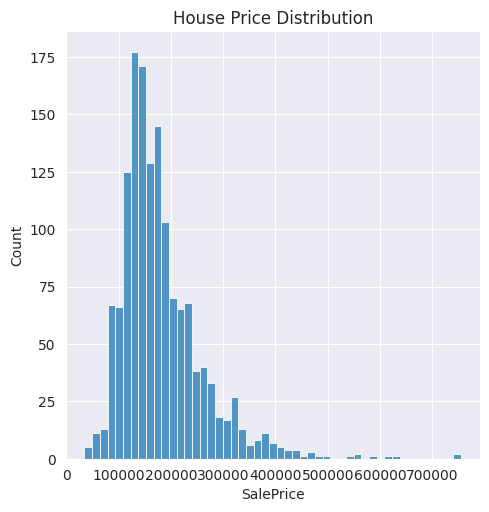

In [81]:
plt.figure(figsize=(8,6))
sns.displot(y)
title = plt.title("House Price Distribution")

The distribution of `SalePrice` is right-skewed. Let's check its Skewness and Kurtosis statistics.

In [82]:
print(f"""Skewness: {y.skew()}
Kurtosis: {y.kurt()}""")

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


<a name="2.2-numerical"></a>
### 2.2. Numerical Features

Top 10 numerical variables highly correlated with `SalePrice`:

In [83]:
corr_mat = train_data.corr().SalePrice.sort_values(ascending=False)
corr_mat.head(11)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

What are the top 10 features selected by [**Recursive Feature Elimination**](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)?

In [84]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=10, step=1)
selector = rfe.fit(X_train.fillna(0).select_dtypes(exclude='object'), y)
selectedFeatures = list(
    X.select_dtypes(exclude='object').columns[selector.support_])
selectedFeatures

['OverallQual',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars']

According to above analyses, **Overall Quality, Living Area, Number of Full Baths, Size of Garage and Year Built** are some of the most important features in determining house price. Let's take a closer look at them.

**Overall Quality**

Overall quality is the most important feature in both analyses. It is clear that higher quality makes the house more expensive.

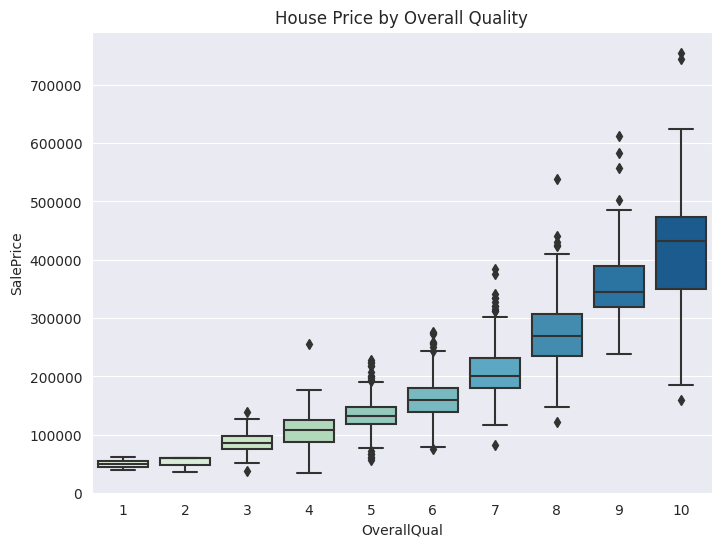

In [85]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_data, palette='GnBu')
title = plt.title('House Price by Overall Quality')

**Living Area**

Living area has a linear relationship with house price. In the scatter plot below, we can clearly see some ***outliers*** in the data, especially the two houses in the lower-right corner with living area greater than ***4000 sqft*** and price lower than ***$200,000***.

Correlation: 0.7086244776126515


<Figure size 600x600 with 0 Axes>

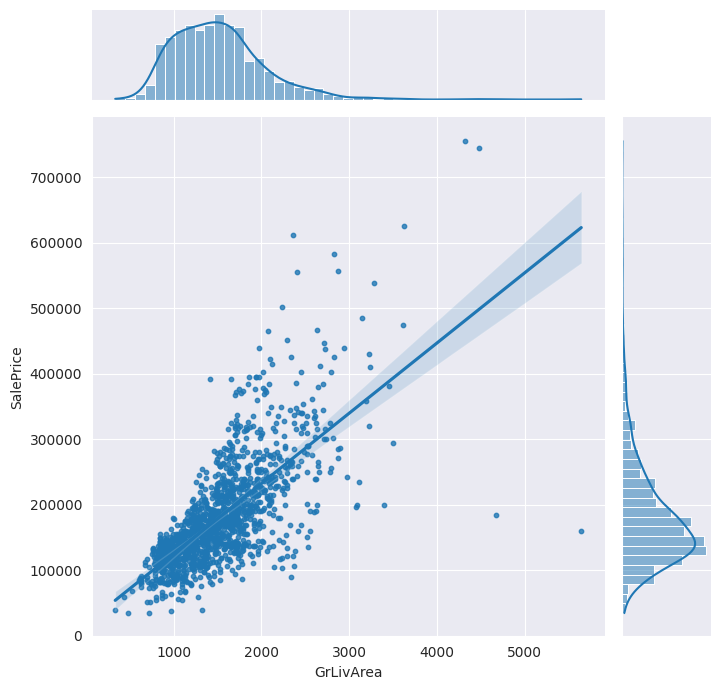

In [87]:
def plotCorrelation(variables):
    """
    1. Print correlation of two variables
    2. Create jointplot of two variables
    """
    # Print correlation
    correlation = train_data[[variables[0], variables[1]]].corr().iloc[1, 0]
    print("Correlation:", correlation)

    # Create jointplot
    plt.figure(figsize=(6, 6))
    sns.jointplot(data=train_data, x=variables[0], y=variables[1], kind='reg', height=7, scatter_kws={'s': 10}, marginal_kws={'kde': True})

# Call the function with the variable names
plotCorrelation(['GrLivArea', 'SalePrice'])


**GarageCars**

Interestingly, houses with garage which can hold 4 cars are cheaper than houses with 3-car garage.

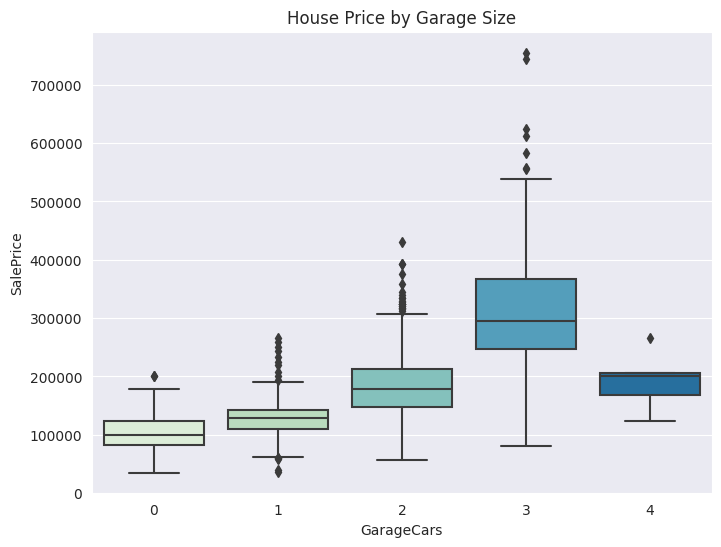

In [88]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='GarageCars', y='SalePrice', data=train_data, palette='GnBu')
title = plt.title('House Price by Garage Size')

**Year Built**

The age of the house also plays an important role in its price. Newer houses have higher average prices. There are several houses built before 1900 having a high price.

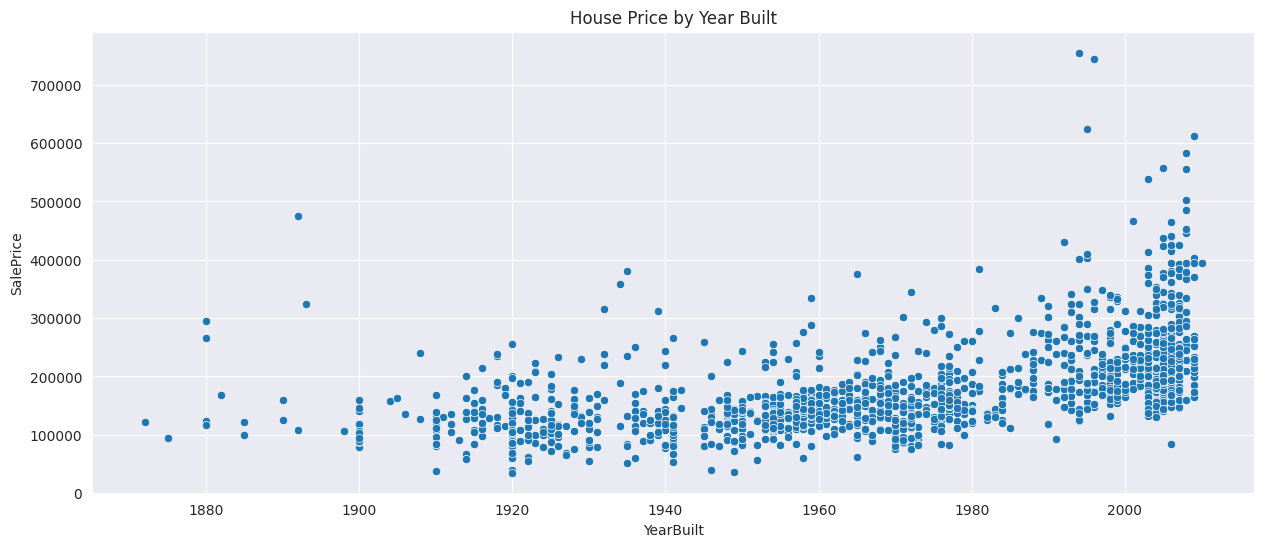

In [89]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='YearBuilt', y='SalePrice', data=train_data)
title = plt.title('House Price by Year Built')

<a name="2.2-categorical"></a>
### 2.3. Categorical Variables

Using **ANOVA**, I have identified 15 categorical features having p-values lower than ***0.01***:

In [90]:
sigCatCols = [
    'Street', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
    'Condition1', 'Condition2', 'RoofMatl', 'ExterQual', 'BsmtQual',
    'BsmtExposure', 'KitchenQual', 'Functional', 'GarageQual', 'PoolQC'
]

Let's explore some of them.

In [91]:
def visualizeCatFeature(feature):
    """
    Visualize the relationship between `SalePrice` and categorical feature using box plots
    """
    # Descending order of levels sorted by median SalePrice
    featOrder = train_data.groupby(
        [feature]).median().SalePrice.sort_values(ascending=False).index

    # Create box plot
    sns.boxplot(x=feature,
                y='SalePrice',
                data=train_data,
                order=featOrder,
                palette='GnBu_r')

**Neighborhood**

There is a big difference in house prices among neighborhood in Ames. The top 3 expensive neighborhoods are **NridgHt, NoRidge and StoneBr** with median house prices of approximately $300,000, three times as high as the median of the 3 cheapest neighborhoods, which are **BrDale, DOTRR and MeadowV**.

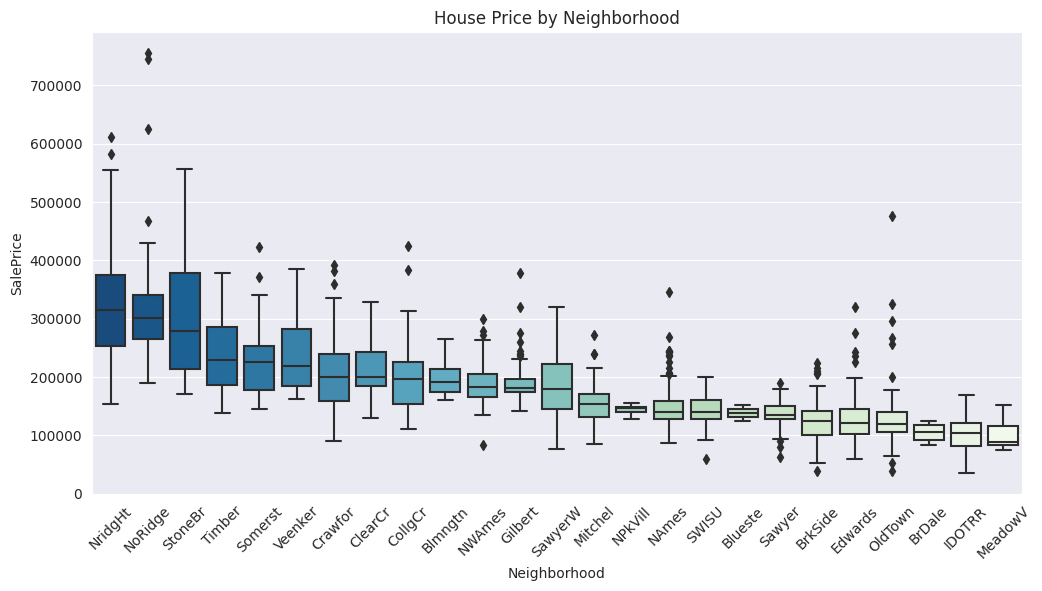

In [92]:
plt.figure(figsize=(12, 6))
visualizeCatFeature('Neighborhood')
title = plt.title('House Price by Neighborhood')
tick = plt.xticks(rotation=45)

**Roof Material**

Houses using **Wood Shingles roof** are the most expensive with price ranging from \\$300,000 to \\$450,000. There are also a lot of expensive houses using **Standard Composite Shingle roof**.

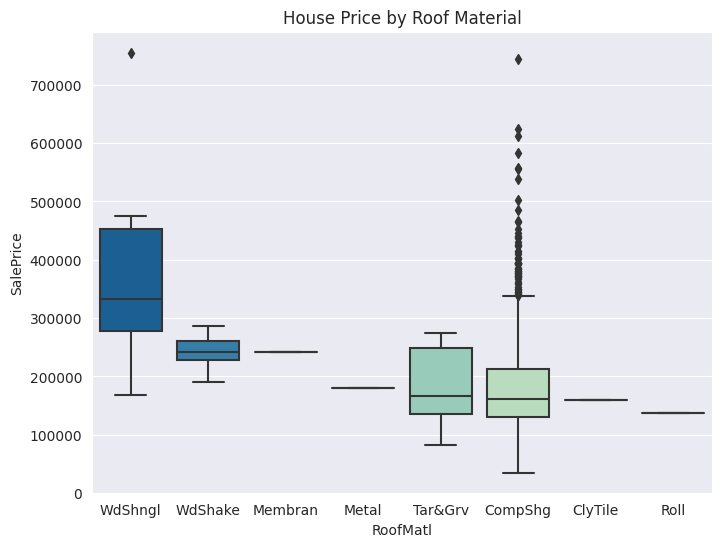

In [93]:
plt.figure(figsize=(8, 6))
visualizeCatFeature('RoofMatl')
title = plt.title('House Price by Roof Material')

**Kitchen Quality**

Kitchen Quality is another important feature to predict house price. There is a very big difference in price between houses with different kitchen quality. For example, the average price difference between a house with a **good** kitchen and one with an **excellent** kitchen is about $120,000.

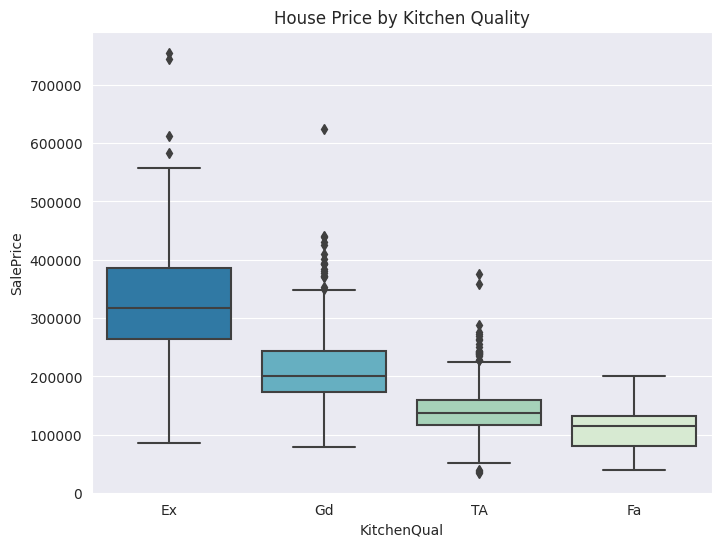

In [94]:
plt.figure(figsize=(8, 6))
visualizeCatFeature('KitchenQual')
title = plt.title('House Price by Kitchen Quality')

<a name="2.4-correlations"></a>
### 2.4. Correlations

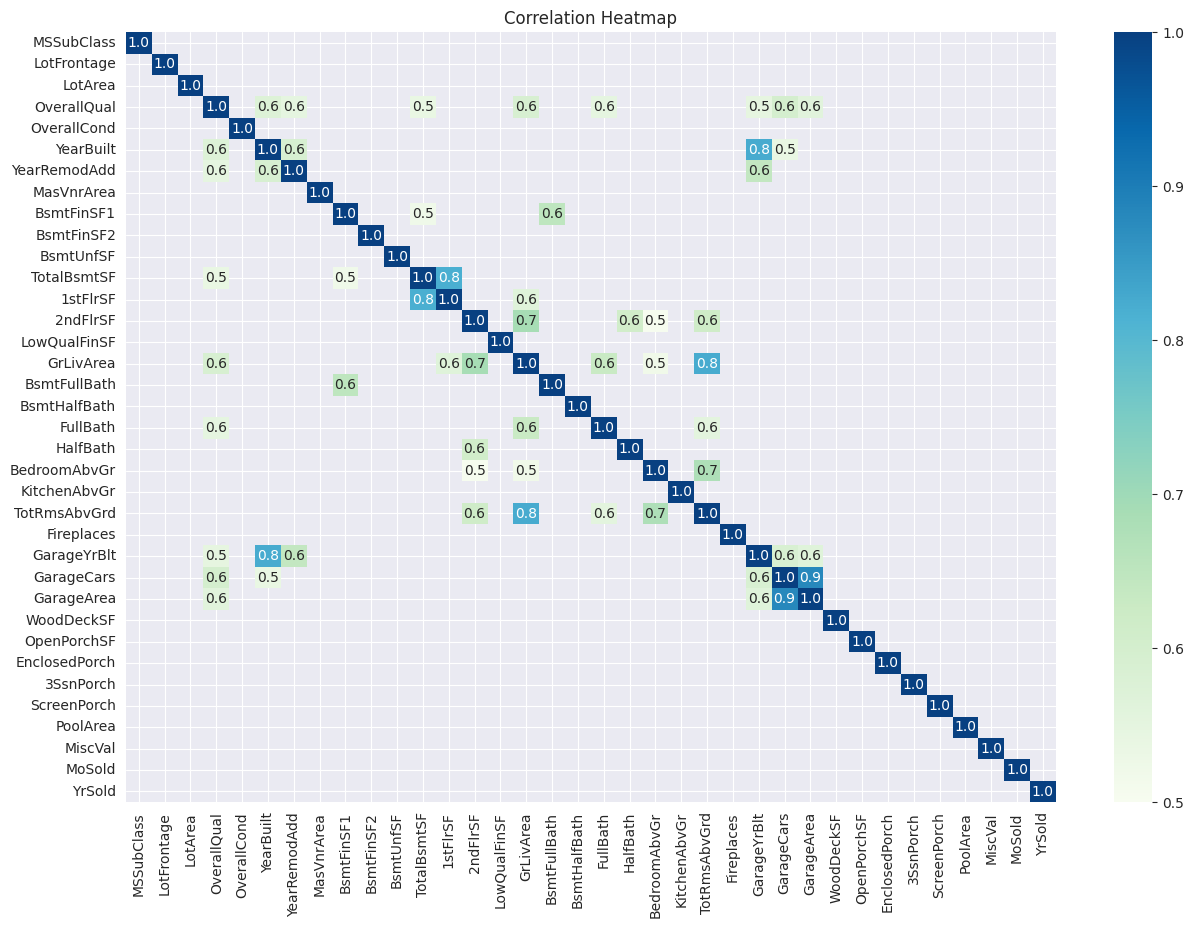

In [95]:
# Create correlation matrix from train data excluding `SalePrice`
corr_mat = train_data.iloc[:, :-1].corr()

# Select correlations greater than 0.5
high_corr_mat = corr_mat[abs(corr_mat) >= 0.5]

# Plot correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(high_corr_mat,
            annot=True,
            fmt='.1f',
            cmap='GnBu',
            vmin=0.5,
            vmax=1)
title = plt.title('Correlation Heatmap')

There is multicollinearity in our training data. Below features are highly correlated:
    - GarageCars and GarageArea
    - GarageYrBlt and YearBuilt
    - 1stFlrSF and TotalBsmtSF
    - GrLivArea and TotRmsAbvGrd
Multicolliniearity has a negative impact on our prediction models and makes standard errors of our estimates increase. Therefore, for each pair of highly correlated features, I will remove a feature that has a lower correlation with `SalePrice`.

<a name="2.5-missing"></a>
### 2.5. Missing Values

Most machine learning algorithms give an error when we train them on data with missing values. Therefore, it's important to identify them before deciding how to handle them (drop features or impute missing value).

In [96]:
missing_data_count = X.isnull().sum()
missing_data_percent = X.isnull().sum() / len(X) * 100

missing_data = pd.DataFrame({
    'Count': missing_data_count,
    'Percent': missing_data_percent
})
missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)

print(f"There are {missing_data.shape[0]} features having missing data.\n")
print("Top 10 missing value features:")
missing_data.head(10)

There are 34 features having missing data.

Top 10 missing value features:


,Count,Percent
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageFinish,159,5.447071
GarageQual,159,5.447071
GarageCond,159,5.447071
GarageYrBlt,159,5.447071


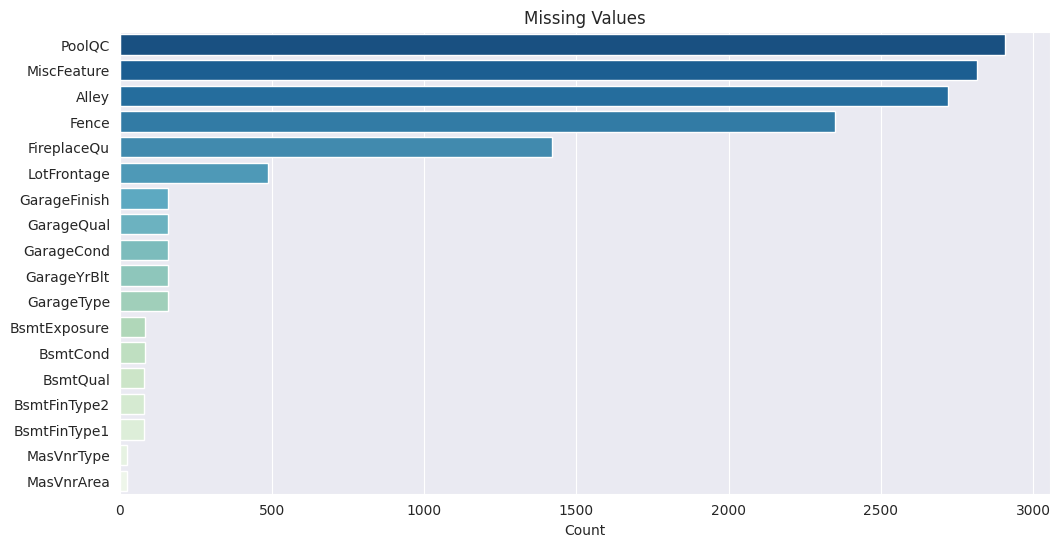

In [97]:
plt.figure(figsize=(12, 6))
sns.barplot(y=missing_data.head(18).index,
            x=missing_data.head(18).Count,
            palette='GnBu_r')
title = plt.title("Missing Values")

With some basic understandings of the data set and features, let's move to data preprocessing and modeling steps.

<a name="3-data-preprocessing"></a>
## 3. Data Preprocessing and Feature Engineering

<a name="3.1-missing-values"></a>
### 3.1. Missing Values

In [98]:
missing_data_count = X.isnull().sum()
missing_data_percent = X.isnull().sum() / len(X) * 100
missing_data = pd.DataFrame({
    'Count': missing_data_count,
    'Percent': missing_data_percent
})
missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)

In [99]:
missing_data.head(10)

,Count,Percent
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageFinish,159,5.447071
GarageQual,159,5.447071
GarageCond,159,5.447071
GarageYrBlt,159,5.447071


There are 34 features that have missing values. I will divide them into three groups based on the data description:
   - **Group 1 - Categorical variables where `NA` means no feature:** `PoolQC`, `MiscFeature`, `Alley`, `Fence`, `FireplaceQu`, `GarageType`, `GarageFinish`, `GarageQual`, `GarageCond`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `MasVnrType` (15 variables)
   
    For this group I will impute `NA` with `'None'`.
    
   - **Group 2 - Numerical variables where `NA` means no feature:** `GarageArea`, `GarageCars`, `BsmtFinSF1`, `BsmtFinSF2`, `BsmtUnfSF`, `TotalBsmtSF`, `BsmtFullBath`, `BsmtHalfBath`, `MasVnrArea` (10 variables)
   
    For this group I will impute `NA` with `0`.
    
   - **Group 3 - Other variables:** `Functional`, `MSZoning`, `Electrical`, `KitchenQual`, `Exterior1st`, `Exterior2nd`, `SaleType`, `Utilities`, `LotFrontage`, `GarageYrBlt` (9 variables)
        - I will impute `Functional`, `MSZoning`, `Electrical`, `KitchenQual`, `Exterior1st`, `Exterior2nd`, `SaleType`, `Utilities` with their *modes*,
        - impute `LotFrontage` with its *mean*,
        - impute `GarageYrBlt` with `YearBuilt`.

In [100]:
from sklearn.impute import SimpleImputer
# Group 1:
group_1 = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]
X[group_1] = X[group_1].fillna("None")

# Group 2:
group_2 = [
    'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
]

X[group_2] = X[group_2].fillna(0)

# Group 3:
group_3a = [
    'Functional', 'MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st',
    'Exterior2nd', 'SaleType', 'Utilities'
]

imputer = SimpleImputer(strategy='most_frequent')
X[group_3a] = pd.DataFrame(imputer.fit_transform(X[group_3a]), index=X.index)

X.LotFrontage = X.LotFrontage.fillna(X.LotFrontage.mean())
X.GarageYrBlt = X.GarageYrBlt.fillna(X.YearBuilt)

Let's check whether there is any missing value left:

In [101]:
sum(X.isnull().sum())

0

Great! All missing values have been handled.

<a name="3.2-outliers"></a>
### 3.2. Outliers

Because regression models are very sensitive to outlier, we need to be aware of them. Let's examine outliers with a scatter plot.

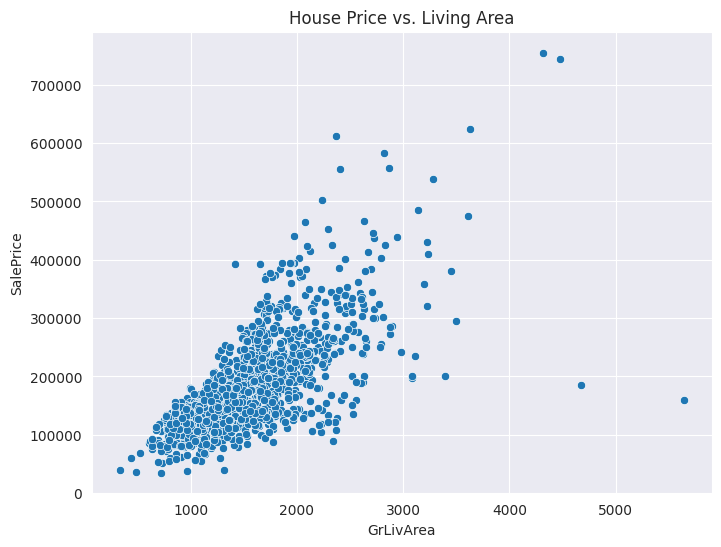

In [102]:
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)
title = plt.title('House Price vs. Living Area')

There are two observations lying separately from the rest. They have large living area but low price. They are the outliers that we are looking for. I will delete them from the training set.

In [103]:
outlier_index = train_data[(train_data.GrLivArea > 4000)
                           & (train_data.SalePrice < 200000)].index
X.drop(outlier_index, axis=0, inplace=True)
y.drop(outlier_index, axis=0, inplace=True)

<a name="3.3-feature-engineering"></a>
### 3.3. Feature Engineering

<a name="3.3.1-create-new-variables"></a>
#### 3.3.1. Create New Variables

In this step I will create new features from weaker features in the training data. For example, the surface area of each floor has low correlation with house price; however, when we sum them up, the relationship becomes much stronger. In fact, `TotalSqFeet` becomes the strongest feature in the dataset. The new features I will create are **total square feet, total number of bathrooms, age of the house, whether the house was remodeled, and whether the house was sold in the same year it was built.**

In [104]:
X['totalSqFeet'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X['totalBathroom'] = X.FullBath + X.BsmtFullBath + 0.5 * (X.HalfBath + X.BsmtHalfBath)
X['houseAge'] = X.YrSold - X.YearBuilt
X['reModeled'] = np.where(X.YearRemodAdd == X.YearBuilt, 0, 1)
X['isNew'] = np.where(X.YrSold == X.YearBuilt, 1, 0)

<a name="3.3.2-label-encoding"></a>
#### 3.3.2. Label Encoding

Ordinal categorical features are label encoded.

In [105]:
from sklearn.preprocessing import LabelEncoder

# Ordinal categorical columns
label_encoding_cols = [
    "Alley", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "BsmtQual", "ExterCond", "ExterQual", "FireplaceQu", "Functional",
    "GarageCond", "GarageQual", "HeatingQC", "KitchenQual", "LandSlope",
    "LotShape", "PavedDrive", "PoolQC", "Street", "Utilities"
]

# Apply Label Encoder
label_encoder = LabelEncoder()

for col in label_encoding_cols:
    X[col] = label_encoder.fit_transform(X[col])

<a name="3.3.3-transform-variables"></a>
#### 3.3.3. Transform Numerical Variables to Categorical Variables

Because I have calculated age of houses, `YearBuilt` is no longer needed. However, `YrSold` could have a large impact on house price (e.g. In economic crisis years, house price could be lower). Therefore, I will transform it into categorical variables.

Like `YrSold`, some numerical variables don't have any ordinal meaning (e.g. `MoSold`, `MSSubClass`). I will transform them into categorical variables.

In [106]:
to_factor_cols = ['YrSold', 'MoSold', 'MSSubClass']

for col in to_factor_cols:
    X[col] = X[col].apply(str)

<a name="3.4-skewness"></a>
### 3.4. Skewness and Normalizing Variables

Normal distribution is one of the assumption that linear regression relies on. Therefore, transfoming skewed data will help our models perform better.

First, let's examine the target variable `SalePrice` with Distribution plot and Quantile-Quantile plot.

**Target variable**

In [107]:
from scipy import stats
from scipy.stats import norm

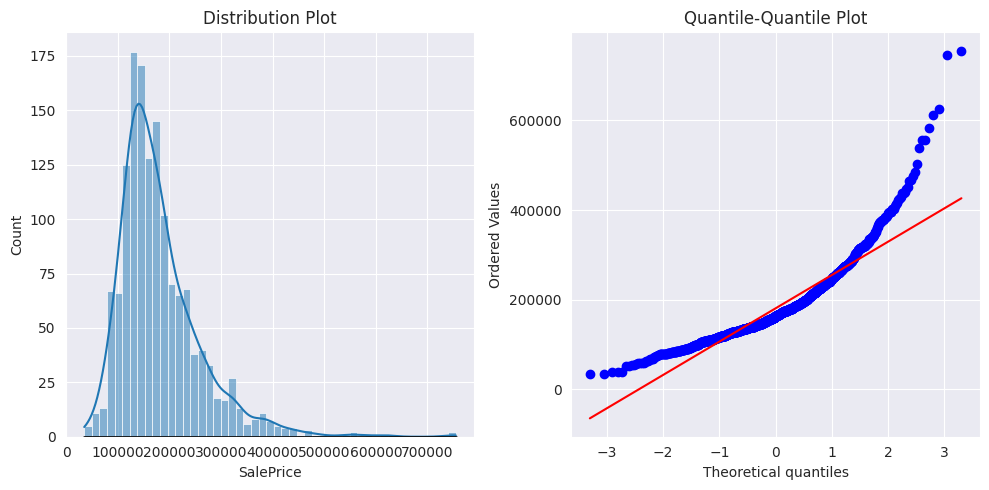

In [114]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot

def normality_plot(X):
    """
    1. Draw a distribution plot with a normal distribution fitted curve
    2. Draw a Quantile-Quantile plot
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Create a histogram using histplot (axes-level function)
    sns.histplot(X, kde=True, ax=axes[0])
    axes[0].set_title('Distribution Plot')

    # Fit a normal distribution curve and overlay it on the histogram
    mu, sigma = norm.fit(X)
    xmin, xmax = min(X), max(X)
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)
    axes[0].plot(x, p, 'k', linewidth=2)

    # Create a Quantile-Quantile plot
    probplot(X, plot=axes[1])
    axes[1].set_title('Quantile-Quantile Plot')

    plt.tight_layout()

# Call the function with your data (in this case, 'y' which is assumed to be the data you want to check for normality)
normality_plot(y)


One of the methods to normalize right-skewed data is using log transformation because big values will be pulled to the center. However, log(0) is Nan, so I will use log(1+X) to fix skewness instead.

In [115]:
y = np.log(1 + y)

And this is `SalePrice` after log transformation. The sknewness has been fixed.

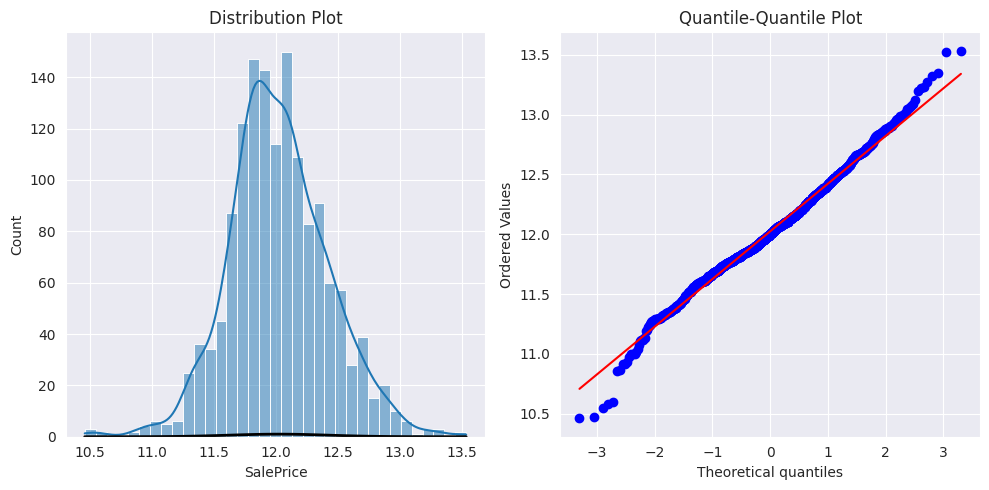

In [116]:
normality_plot(y)

In the next step I will examine skewness in the rest of numerical variables and use log transformation to fix them,

**Fixing skewness in other numerical variables**

If skewness is less than -1 or greater than 1, the distribution is **highly skewed**.

If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is **moderately skewed**.

If skewness is between -0.5 and 0.5, the distribution is **approximately symmetric**.

Below are skewed features in our original train data.

In [117]:
skewness = train_data.skew().sort_values(ascending=False)
skewness[abs(skewness) > 0.75]

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
MasVnrArea        2.669084
OpenPorchSF       2.364342
LotFrontage       2.163569
SalePrice         1.882876
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
MSSubClass        1.407657
1stFlrSF          1.376757
GrLivArea         1.366560
BsmtUnfSF         0.920268
2ndFlrSF          0.813030
dtype: float64

Let's check normality of `GrLivArea`:

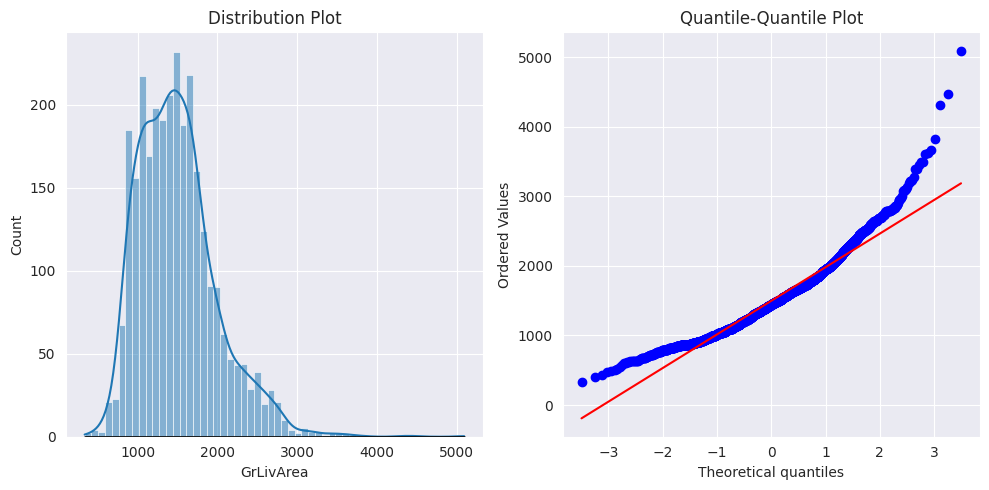

In [118]:
normality_plot(X.GrLivArea)

In [119]:
# List of skewed columns
skewed_cols = list(skewness[abs(skewness) > 0.5].index)

# Remove 'MSSubClass' and 'SalePrice'
skewed_cols = [
    col for col in skewed_cols if col not in ['MSSubClass', 'SalePrice']
]

# Log-transform skewed columns
for col in skewed_cols:
    X[col] = np.log(1 + X[col])

Below is normality of `GrLivArea` after log-transformation. Skewness has been fixed.

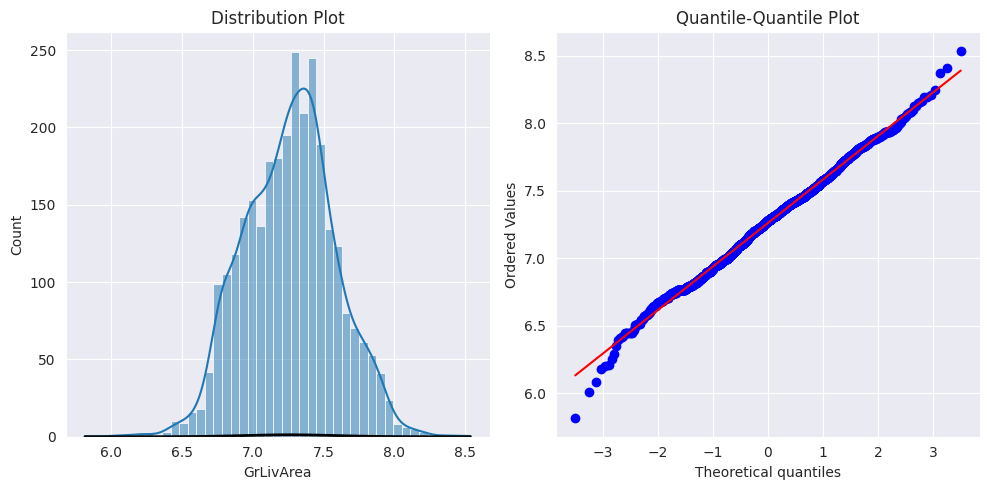

In [120]:
normality_plot(X.GrLivArea)

<a name="3.5-feature-scaling"></a>
### 3.5. Feature Scaling

Except for Decision Tree and Random Forest, it is highly recommended to standardize the data set before running machine learning algorithms since optimization methods and gradient descent run and converge faster on similarly scaled features.

However, outliers can often influence the sample mean and standard deviation in a negative way, and models like Lasso and Elastic Net are very sensitive to outliers. In such cases, the median and the interquartile range often give better results. I will use [**RobustScaler**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) to transform the training data.

In [121]:
from sklearn.preprocessing import RobustScaler
numerical_cols = list(X.select_dtypes(exclude=['object']).columns)
scaler = RobustScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

<a name="3.6-one-hot-encoding"></a>
### 3.6. One-hot Encoding

In [122]:
X = pd.get_dummies(X, drop_first=True)
print("X.shape:", X.shape)

X.shape: (2917, 237)


After preprocessing the train and test data, I split them again to perform modeling.

In [123]:
ntest = len(test_data)
X_train = X.iloc[:-ntest, :]
X_test = X.iloc[-ntest:, :]
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)

X_train.shape: (1458, 237)
X_test.shape: (1459, 237)


<a name="4-modeling"></a>
## 4. Modeling

In model evaluation, it's a common practice to split the entire training data into 2 sets of data (train and test). However, a model may work very well on a set of test data but have a poor performance on other sets of unseen data.

A solution to this problem is a procedure called [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) (CV). In the example below, under the basic approach, called k-fold CV, the training set is split into `5` smaller sets. Then, for each fold, a model is trained using the other `4` folds and evaluated on the remaining fold. The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="400" height="200" alt="CV">

I will write a function to get the **Root Mean Squared Logarithmic Error (RMSLE)** for my models using cross-validation. There is one note here: because I have transformed the target variable to *log(1+y)* , the **Mean Squared Error** for *log(1+y)* is the **Mean Squared Logarithmic Error** for `SalePrice`.

In [124]:
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5


def getRMSLE(model):
    """
    Return the average RMSLE over all folds of training data.
    """
    # Set KFold to shuffle data before the split
    kf = KFold(n_folds, shuffle=True, random_state=42)

    # Get RMSLE score
    rmse = np.sqrt(-cross_val_score(
        model, X_train, y, scoring="neg_mean_squared_error", cv=kf))

    return rmse.mean()

<a name="4.1-regularized-regression"></a>
### 4.1. Regularized Regressions

In [125]:
from sklearn.linear_model import Ridge, Lasso

<a name="4.1.1-ridge"></a>
#### 4.1.1. Ridge Regression

In the regularized linear regression (Ridge), we try to minimize:

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n \theta_j^2 \right)$$

where $\lambda$ is a regularization parameter which controls the degree of regularization (thus, help preventing overfitting). The regularization term puts a penalty on the overall cost J. As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well.

I will find the $\lambda$ that gives me the smallest **RMSLE** from cross-validation:

Best lambda: 22.9
RMSLE: 0.11409306668450885


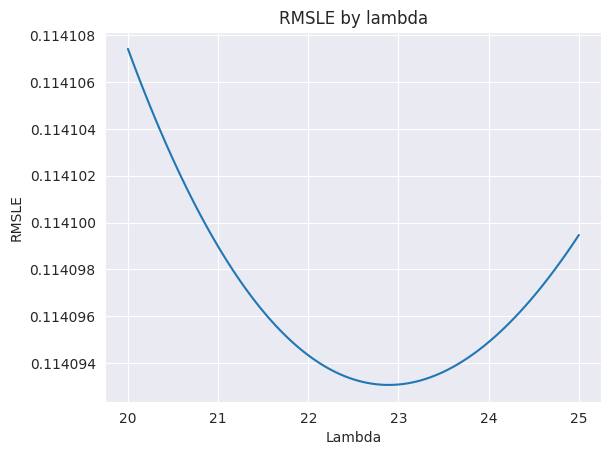

In [143]:
lambda_list = list(np.linspace(20, 25, 101))

rmsle_ridge = [getRMSLE(Ridge(alpha=lambda_)) for lambda_ in lambda_list]
rmsle_ridge = pd.Series(rmsle_ridge, index=lambda_list)

rmsle_ridge.plot(title="RMSLE by lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_ridge.idxmin())
print("RMSLE:", rmsle_ridge.min())

In [51]:
ridge = Ridge(alpha=22.9)

<a name="4.1.2-lasso"></a>
#### 4.1.2. Lasso Regression

Lasso Regression is very similar to Ridge regression. One difference is that in the regularization term, instead of using **sum of squared of $\theta$**, we use **sum of absolute value of $\theta$**:

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n |\theta_j| \right)$$

Another big difference is that Ridge Regresion can only shrink parameters close to zero while Lasso Regression can shrink some parameters all the way to 0. Therefore, we can use Lasso Regression to perform feature selection and regression.

With the same method above, the best `lambda_` for my Lasso model is **0.00065**.

Best lambda: 0.00065
RMSLE: 0.1133570157806129


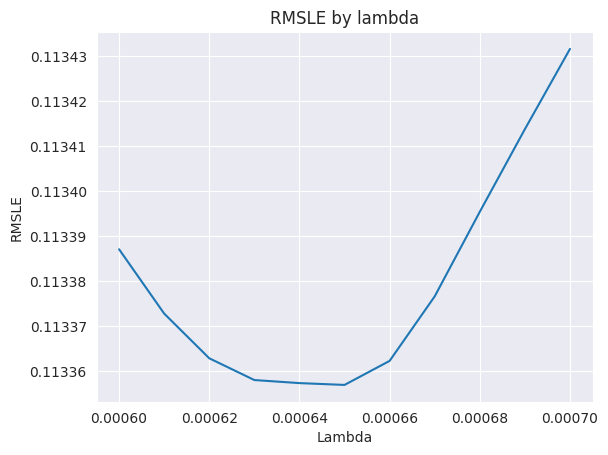

In [127]:
lambda_list = list(np.linspace(0.0006, 0.0007, 11))
rmsle_lasso = [
    getRMSLE(Lasso(alpha=lambda_, max_iter=100000)) for lambda_ in lambda_list
]
rmsle_lasso = pd.Series(rmsle_lasso, index=lambda_list)

rmsle_lasso.plot(title="RMSLE by lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_lasso.idxmin())
print("RMSLE:", rmsle_lasso.min())

In [128]:
lasso = Lasso(alpha=0.00065, max_iter=100000)

<a name="4.2-xgboost"></a>
### 4.2. XGBoost I WILL NOT DO THIS FOR MY PROJECT
Following this [complete guide](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/?fbclid=IwAR1NTAXqgYzjOOFw3qOV5DrcItwNoM73iPvWggnuyVR1PbvORiEUjRunipo) of parameter tuning for XGBoost, I respectively tune and find the best parameter for  `n_estimators` `max_depth` `min_child_weight` `gamma` `subsample` `colsample_bytree` `reg_alpha` `reg_lambda` `learning_rate`.

In [129]:
from xgboost import XGBRegressor

In [140]:
xgb = XGBRegressor(learning_rate=0.05,
                   n_estimators=2100,
                   max_depth=2,
                   min_child_weight=2,
                   gamma=0,
                   subsample=0.65,
                   colsample_bytree=0.46,
                   nthread=-1,
                   scale_pos_weight=1,
                   reg_alpha=0.464,
                   reg_lambda=0.8571,
                   verbosity=0,  # Use 'verbosity' instead of 'silent'
                   random_state=7,
                   n_jobs=2)

getRMSLE(xgb)


0.11704386812326902

<a name="4.3-lightgbm"></a>
### 4.3. LightGBM (I WILL NOT BE DOING THIS STEP FOR MY PROJECT)

LightGBM is a powerful gradient boosting framework based on decision tree algorithm. Like XGBoost, LightGBM has a high performance on large data sets  but much faster training speed than XGBoost does. Following [this guide](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/?fbclid=IwAR3uYr9U1VDaqh_jEn1cjvMyjEWVHKMaDm_Q9yD1y08OkGBywRR0qpuhhtw), I have tuned the parameters `num_leaves` `min_data_in_leaf` `max_depth` `bagging_fraction` `feature_fraction` `max_bin`. As you can see in the RMSLE reported below, for this data set LightGBM has better performance than XGBoost.

In [141]:
from lightgbm import LGBMRegressor

<a name="4.4-averaging-model"></a>
### 4.4. Averaging Model

Regularized regression and gradient boosting work very differently and they may perform well on different data points. Thus it is a good practice to get average predictions from these models. Below I create a new class for my averaging model.

In [157]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone


class AveragingModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        # Create clone models
        self.models_ = [clone(x) for x in self.models]

        # Train cloned models
        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        # Get predictions from trained clone models
        predictions = np.column_stack(
            [model.predict(X) for model in self.models_])

        # Return average predictions
        return np.mean(predictions, axis=1)

In [156]:
from sklearn.linear_model import Lasso

# Define and configure the Lasso model
lasso = Lasso(alpha=0.1)  # You can specify the alpha (regularization strength) as needed

# Now you can create the AveragingModel with all the models
avg_model = AveragingModel(models=(ridge, lasso))


In [155]:
avg_model = AveragingModel(models=(ridge, lasso))
getRMSLE(avg_model)

0.15006901228254269

The RMSLE score of the averaging model is much better than any of base models. I will use this model as my final model. In the last step, I will train my final model on the whole training data, make predictions from the test data and save my output.

In [154]:
my_model = avg_model
my_model.fit(X_train, y)
predictions = my_model.predict(X_test)
final_predictions = np.exp(predictions) - 1
output = pd.DataFrame({'Id': test_data.index, 'SalePrice': final_predictions})
output.to_csv('submission.csv', index=False)

<a name="5-conclusion"></a>
## 5. Conclusion

In this project, I have conducted a detailed EDA to understand the data and important features. Based on exploratory analysis, I performed data preprocessing and feature engineering. Finally, I train regularized regression models (Ridge, Lasso), XGBoost and LightGBM, and take average predictions from these models to predict final price of each house. By the time I write this notebook, my best model has **Mean Absolute Error** of **12293.919**, ranking 95/15502, approximately top 0.6% in the Kaggle leaderboard.

<a name="6-reference"></a>
## 6. Reference

Below are some excellent notebooks about this dataset that I have read and learned a lot from, including smart techniques such as Q-Q plots and averaging model:
- [Stacked regressions to predict house prices](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
- [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)
- [Regularized linear models](https://www.kaggle.com/apapiu/regularized-linear-models)

Thank you for reading. I hope you enjoy it. Please feel free to contact me if you have any question. If you are interested in other projects that I have done, please visit my website at https://chriskhanhtran.github.io/.

**Other projects:**
- [Predict Breast Cancer with RF, PCA and SVM using Python](https://chriskhanhtran.github.io/projects/breast-cancer.html)
- [Detect Spam Messages - Natural Language Processing using Python](https://chriskhanhtran.github.io/projects/detect-spam-nlp.html)